# Networks with flows and spatial interaction models

Now, in this part, we will consider the flows, i.e. taking into consideration the number of prople that need to travel from one place to another.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from networkx import algorithms 
from networkx.algorithms import efficiency
from networkx.algorithms import components
from networkx.algorithms.efficiency_measures import global_efficiency
from networkx.algorithms.components import connected_components

## Preprocessing

### London's underground network shapefile

First we need to read the shape file of the network and do some preprocessing

In [2]:
os.chdir('.\\Underground')

In [740]:
g_shp=nx.read_shp('underground.shp',geom_attrs=False) 

In [741]:
list(g_shp.nodes(data=True))[0:10]

[((-0.1571, 51.5226), {}),
 ((-0.1631, 51.5225), {}),
 ((-0.1466, 51.5234), {}),
 ((-0.1247, 51.508), {}),
 ((-0.1223, 51.5074), {}),
 ((-0.1342, 51.5098), {}),
 ((-0.1679, 51.5199), {}),
 ((-0.1755, 51.5154), {}),
 ((-0.1001, 51.4943), {}),
 ((-0.1115, 51.4991), {})]

We realize that there are no stations' name in the nodes' attributes. So we decide to add them (extract from the edgelist and add it to nodes' attribute).

In [742]:
nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}
nod_all = nod_st1.copy()
nod_all.update(nod_st2)
nx.set_node_attributes(g_shp,nod_all,'station')

In [743]:
list(g_shp.nodes(data=True))[0:10]

[((-0.1571, 51.5226), {'station': 'Baker Street'}),
 ((-0.1631, 51.5225), {'station': 'Marylebone'}),
 ((-0.1466, 51.5234), {'station': "Regent's Park"}),
 ((-0.1247, 51.508), {'station': 'Charing Cross'}),
 ((-0.1223, 51.5074), {'station': 'Embankment'}),
 ((-0.1342, 51.5098), {'station': 'Picadilly Circus'}),
 ((-0.1679, 51.5199), {'station': 'Edgware Road (B)'}),
 ((-0.1755, 51.5154), {'station': 'Paddington'}),
 ((-0.1001, 51.4943), {'station': 'Elephant & Castle'}),
 ((-0.1115, 51.4991), {'station': 'Lambeth North'})]

Now our nodes have the stations' names.

Next, because we will link this graph with a csv file that contains the flows data, we need to give them the same ID for stations.We need to transform our old index of nodes (that is the coordinates) into new ID. And at the same time, the coordinate data will be stored into our nodes attributes.

In [744]:
#give an ID to each node(station)

g_shp_un=g_shp.to_undirected()

#1.Create a new attribute with node coordinates (now coord are the keys and we do not want to lose that information
nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,nod_coord,'station_coord')

#2.now relabel each node with an ordered integer:
node_list = list(g_shp_un.nodes())
mapping = {node_list[i]:i for i in range(len(node_list))}
g_shp_un = nx.relabel_nodes(g_shp_un, mapping)

#Later when using the Commuters data we will have an issue mapping node 'Heathrow Terminals 1, 2 & 3', 
#so we are going to rename it here:
#1. find the node 'Heathrow Terminals 1, 2 & 3'
nodes = [(x,y) for x,y in g_shp_un.nodes(data='station') if 'Heathrow' in str(y)]

#2.Rename it with the name given by the the commuters file (see later):
g_shp_un.nodes[258]['station']='Heathrow Terminals 123'

Now, check our results:

In [74]:
list(g_shp_un.nodes(data=True))[0:10]

[(0, {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)}),
 (1, {'station': 'Marylebone', 'station_coord': (-0.1631, 51.5225)}),
 (2, {'station': "Regent's Park", 'station_coord': (-0.1466, 51.5234)}),
 (3, {'station': 'Charing Cross', 'station_coord': (-0.1247, 51.508)}),
 (4, {'station': 'Embankment', 'station_coord': (-0.1223, 51.5074)}),
 (5, {'station': 'Picadilly Circus', 'station_coord': (-0.1342, 51.5098)}),
 (6, {'station': 'Edgware Road (B)', 'station_coord': (-0.1679, 51.5199)}),
 (7, {'station': 'Paddington', 'station_coord': (-0.1755, 51.5154)}),
 (8, {'station': 'Elephant & Castle', 'station_coord': (-0.1001, 51.4943)}),
 (9, {'station': 'Lambeth North', 'station_coord': (-0.1115, 51.4991)})]

In [765]:
#create a dataframe to store the name and the ID
StationNames=[]
for i in range(0,len(list(g_shp_un.nodes(data=True)))):
    StationNames.append(list(g_shp_un.nodes(data=True))[i][1]['station'])

### CSV of flows

Now, read the csv that contain the infomation about flows.

In [10]:
orig_dest=pd.read_csv('ODtube2017.csv')

In [11]:
orig_dest

,From,station_name,To,station_name.1,total_wtrips
0,500,Acton Town,505,Alperton,143
1,500,Acton Town,506,Amersham,22
2,500,Acton Town,507,Angel,15
3,500,Acton Town,508,Archway,9
4,500,Acton Town,510,Arsenal,9
...,...,...,...,...,...
34053,771,Woodside Park,747,Waterloo,93
34054,771,Woodside Park,755,West Brompton,0
34055,771,Woodside Park,756,West Finchley,34
34056,771,Woodside Park,761,Westminster,51


In [12]:
orig_dest[orig_dest.station_name=='Hammersmith']

,From,station_name,To,station_name.1,total_wtrips
12113,593,Hammersmith,500,Acton Town,430
12114,593,Hammersmith,503,Aldgate East,46
12115,593,Hammersmith,505,Alperton,322
12116,593,Hammersmith,506,Amersham,7
12117,593,Hammersmith,507,Angel,98
...,...,...,...,...,...
12384,773,Hammersmith,757,West Ham,0
12385,773,Hammersmith,758,West Hampstead,0
12386,773,Hammersmith,754,Westbourne Park,437
12387,773,Hammersmith,764,White City,22


We notice that Hammersmith has two different ID. Checking its destinations to investigate if there are repeated records.

In [13]:
List=list(orig_dest[orig_dest.station_name=='Hammersmith']['station_name.1'])
a = {}
for i in List:
    if List.count(i)>1:a[i] = List.count(i)

In [14]:
a

{'Aldgate East': 2,
 'Angel': 2,
 'Baker Street': 2,
 'Barbican': 2,
 'Belsize Park': 2,
 'Blackhorse Road': 2,
 'Chancery Lane': 2,
 'Croxley': 2,
 'Ealing Broadway': 2,
 'East Ham': 2,
 'Eastcote': 2,
 'Edgware Road (C)': 2,
 'Farringdon': 2,
 'Finchley Road': 2,
 'Harrow & Wealdston': 2,
 'Harrow-on-the-Hill': 2,
 'High Street Kensington': 2,
 'Highbury & Islington': 2,
 'Holborn': 2,
 'Kentish Town': 2,
 'Kilburn': 2,
 "King's Cross St. Pancras": 2,
 'Kingsbury': 2,
 'Liverpool Street': 2,
 'Mansion House': 2,
 'Marylebone': 2,
 'Mile End': 2,
 'Mill Hill East': 2,
 'Moorgate': 2,
 'Neasden': 2,
 'Northolt': 2,
 'Northwick Park': 2,
 'Paddington': 2,
 'Plaistow': 2,
 'Rickmansworth': 2,
 "St. John's Wood": 2,
 'Stanmore': 2,
 'Stratford': 2,
 'Swiss Cottage': 2,
 'Tottenham Hale': 2,
 'Tufnell Park': 2,
 'Walthamstow Central': 2,
 'Watford': 2,
 'West Ham': 2,
 'West Hampstead': 2,
 'White City': 2,
 'Willesden Green': 2}

So we have to merge them.Add the data of 773 to that of 593.

In [15]:
#create a new list to store the repeated destination
list1=list(a.keys())

In [16]:
df=orig_dest[orig_dest.station_name=='Hammersmith']
df1=df[df.From==593]
df2=df[df.From==773]

for i in df1.index:
    for j in list1:
        if df['station_name.1'][i]==j:
            ind=df2[df2['station_name.1']==j].index
            orig_dest['total_wtrips'][i]=orig_dest['total_wtrips'][i]+orig_dest['total_wtrips'][ind]

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Then we delete the rows where Hammersmith's ID is 773.

In [17]:
orig_dest=orig_dest.drop(index=(orig_dest.loc[(orig_dest['From']==773)].index))

Now we do that to rows where destination is Hammersmith.

In [18]:
b = {}
for i in list(orig_dest[orig_dest['station_name.1']=='Hammersmith']['station_name']):
    if list(orig_dest[orig_dest['station_name.1']=='Hammersmith']['station_name']).count(i)>1:b[i] =list(orig_dest[orig_dest['station_name.1']=='Hammersmith']['station_name']).count(i)

list2=list(b.keys())

df=orig_dest[orig_dest['station_name.1']=='Hammersmith']
df1=df[df.To==593]
df2=df[df.To==773]

for i in df1.index:
    for j in list2:
        if df['station_name'][i]==j:
            ind=df2[df2['station_name']==j].index
            orig_dest['total_wtrips'][i]=orig_dest['total_wtrips'][i]+orig_dest['total_wtrips'][ind]

orig_dest=orig_dest.drop(index=(orig_dest.loc[(orig_dest['To']==773)].index))

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


We can transform it into a network.

In [19]:
g_OD = nx.from_pandas_edgelist(orig_dest, 'station_name', 'station_name.1',['total_wtrips'],create_using=nx.MultiDiGraph)

In [20]:
list(g_OD.edges(data=True))[1:10]

[('Acton Town', 'Amersham', {'total_wtrips': 22}),
 ('Acton Town', 'Angel', {'total_wtrips': 15}),
 ('Acton Town', 'Archway', {'total_wtrips': 9}),
 ('Acton Town', 'Arsenal', {'total_wtrips': 9}),
 ('Acton Town', 'Baker Street', {'total_wtrips': 19}),
 ('Acton Town', 'Bank', {'total_wtrips': 226}),
 ('Acton Town', 'Barbican', {'total_wtrips': 7}),
 ('Acton Town', 'Barons Court', {'total_wtrips': 36}),
 ('Acton Town', 'Bayswater', {'total_wtrips': 2})]

We need to change the station names to the ID to be consistent with `g_shp_un`, which will be convinient for adding attributes.

In [21]:
#1.Copy name as an attribute:
nod_names={(e1):e1 for e1 in g_OD.nodes()}
nx.set_node_attributes(g_OD,nod_names,'station') #with nod_id1 or nod_id2 is enought

#2.Do the mapping with id in g_shp_un
mapping = {g_shp_un.nodes[i]['station']:i for i in g_shp_un.nodes()}
g_OD = nx.relabel_nodes(g_OD, mapping)

#add coodenates to the nodes, from the shapefile of the tube network:
nod_coords={(e1):coord for e1, coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_OD,nod_coords,'station_coord') #with nod_id1 or nod_id2 is enought
pos = {e1: xy for e1,xy in g_OD.nodes(data='station_coord')}

Now we get the network with the nodes coordinates.Check what information it contains. 

In [22]:
list((g_OD.nodes(data=True)))[0:10]

[(111, {'station': 'Acton Town', 'station_coord': (-0.2801, 51.5028)}),
 (238, {'station': 'Alperton', 'station_coord': (-0.2997, 51.5407)}),
 (172, {'station': 'Amersham', 'station_coord': (-0.607, 51.6736)}),
 (196, {'station': 'Angel', 'station_coord': (-0.1058, 51.5322)}),
 (198, {'station': 'Archway', 'station_coord': (-0.1353, 51.5653)}),
 (244, {'station': 'Arsenal', 'station_coord': (-0.1059, 51.5586)}),
 (0, {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)}),
 (25, {'station': 'Bank', 'station_coord': (-0.0886, 51.5133)}),
 (77, {'station': 'Barbican', 'station_coord': (-0.0979, 51.5204)}),
 (100, {'station': 'Barons Court', 'station_coord': (-0.2139, 51.4905)})]

In [23]:
list(g_OD.edges(data=True))[0:10]

[(111, 238, {'total_wtrips': 143}),
 (111, 172, {'total_wtrips': 22}),
 (111, 196, {'total_wtrips': 15}),
 (111, 198, {'total_wtrips': 9}),
 (111, 244, {'total_wtrips': 9}),
 (111, 0, {'total_wtrips': 19}),
 (111, 25, {'total_wtrips': 226}),
 (111, 77, {'total_wtrips': 7}),
 (111, 100, {'total_wtrips': 36}),
 (111, 80, {'total_wtrips': 2})]

But this network is not the real commuting networks and we dont have the coordinates infomation.We will:

   * calculate the actual flow of commuters travelling between each pair of stations based on the shortest path assumption
   * add the coordinates to the stations
   * add the names of stations

Then we can create the network with the actual flow of commuters travelling between each pair of stations.

In [24]:
N=len(g_shp_un.nodes())
adj_c=np.zeros((N, N))


for e1,e2,C in g_OD.edges(data='total_wtrips'):
    path = nx.dijkstra_path(g_shp_un,e1,e2) 
    path_edges = list(zip(path,path[1:])) 
    for (s1,s2) in path_edges:
        adj_c[s1,s2]=adj_c[s1,s2]+C 
        
g_flows=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)

#give coordinates to these nodes:
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_flows,nod_coord,'station_coord')

#also the station names:
nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(g_flows,nod_names,'station')

Now we have the real flows `g_flows`.

In [25]:
list((g_flows.nodes(data=True)))[0:10]

[(0, {'station_coord': (-0.1571, 51.5226), 'station': 'Baker Street'}),
 (1, {'station_coord': (-0.1631, 51.5225), 'station': 'Marylebone'}),
 (2, {'station_coord': (-0.1466, 51.5234), 'station': "Regent's Park"}),
 (3, {'station_coord': (-0.1247, 51.508), 'station': 'Charing Cross'}),
 (4, {'station_coord': (-0.1223, 51.5074), 'station': 'Embankment'}),
 (5, {'station_coord': (-0.1342, 51.5098), 'station': 'Picadilly Circus'}),
 (6, {'station_coord': (-0.1679, 51.5199), 'station': 'Edgware Road (B)'}),
 (7, {'station_coord': (-0.1755, 51.5154), 'station': 'Paddington'}),
 (8, {'station_coord': (-0.1001, 51.4943), 'station': 'Elephant & Castle'}),
 (9, {'station_coord': (-0.1115, 51.4991), 'station': 'Lambeth North'})]

In [26]:
list((g_flows.edges(data=True)))[0:10]

[(0, 1, {'weight': 15400.0}),
 (0, 2, {'weight': 36470.0}),
 (0, 33, {'weight': 122309.0}),
 (0, 75, {'weight': 99034.0}),
 (0, 76, {'weight': 70420.0}),
 (0, 152, {'weight': 12433.0}),
 (0, 165, {'weight': 77319.0}),
 (1, 0, {'weight': 15035.0}),
 (1, 6, {'weight': 5231.0}),
 (2, 0, {'weight': 19675.0})]

In [27]:
nx.to_pandas_edgelist(g_flows)

,source,target,weight
0,0,1,15400.0
1,0,2,36470.0
2,0,33,122309.0
3,0,75,99034.0
4,0,76,70420.0
...,...,...,...
617,274,270,36909.0
618,275,93,100921.0
619,275,276,52400.0
620,276,221,39715.0


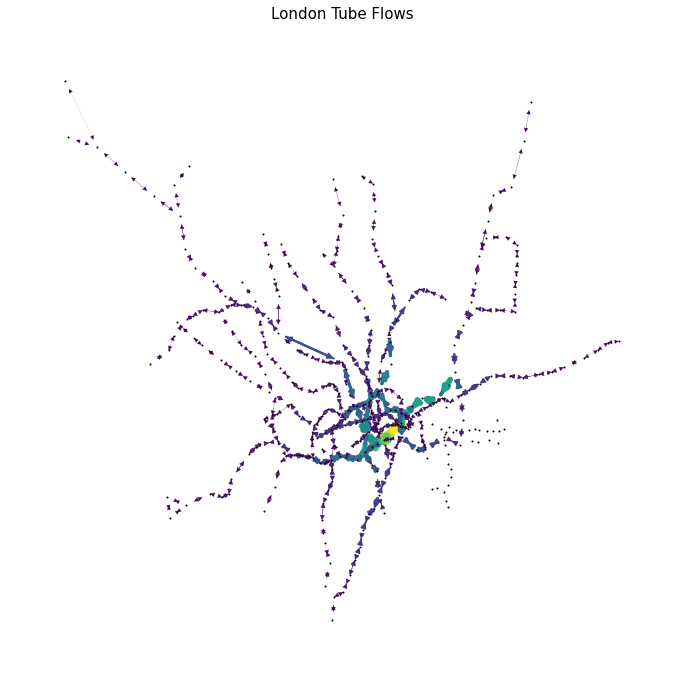

In [28]:
# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in g_flows.edges(data='weight')]

weights_color=[(w/max(weights)) for e1,e2,w in g_flows.edges(data='weight')]
weights_size=[(w/max(weights)*10) for e1,e2,w in g_flows.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in g_flows.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(g_flows, pos,edge_color=weights_color, width=weights_size)

nx.draw_networkx_nodes(g_flows,pos = pos,node_color= 'black',node_size= 1)

plt.axis("off")
plt.title("London Tube Flows",fontsize=15)
plt.show()

#this are the directed flows in the tube network!

## Recompute the impact in previous analysis

In [29]:
g_shp_2=g_flows.to_undirected()

Considering weights, strength of a node can be introduced to give the network a more meaningful description\cite{xing2017vulnerability}, which can be defined as follows:

$s_{i}=\sum_{j=1}^{N}a_{ij}w_{ij}$

where $a_{ij}=1$ when a link exists between nodes $i$ and $j$ and $a_{ij}=0$ otherwise. $s_{i}$ represents the strength of node $i$, and $w_{ij}$ refers the weight.

For the weight case, the indicator of the relative size of the maximal connected sub-graph ($S$) can be improved as follow:


$S_{w}=s_{max}/s$ 

where $s_{max}$ is the sum of strength of nodes on the largest connected sub-graph after attack, and $s$ is the sum of strength of nodes on the initial network. Based on the improved measure, the impact of removing nodes on the network can be evaluated again.


First, we need to redefined our fuction of calculate the impact.

In [30]:
# inverse the flows to create the actural weight
new_weight={}
for e1,e2,c in g_shp_2.edges(data='weight'):
    new_weight[(e1,e2)]=1/c
nx.set_edge_attributes(g_shp_2,new_weight,'new_weight')

# calculate the sum of strenght in the initial graph
s_initial=g_shp_2.degree(weight='new_weight')
s_df=pd.DataFrame.from_dict(dict(s_initial),columns=['strenght'],orient='index')
s=s_df.strenght.sum()

In [31]:
s

0.1324375647789767

In [32]:
def rsmcs_weight(g):
    '''
    This function is the improved method to evaluate the impact on the network after nodes removal.
    It gets the value of relative size of the maximal connected sub-graph taking weight into consideration.
    '''
  
    # find the largest connected subgraph
    largest_cc = g.subgraph(max(nx.connected_components(g), key=len))
    
    # calculate the sum of strenght in this subgraph
    s_initial=largest_cc.degree(weight='new_weight')
    s_df=pd.DataFrame.from_dict(dict(s_initial),columns=['strenght'],orient='index')
    s_max=s_df.strenght.sum()
    
    return s_max/0.1324375647789767

In [33]:
################  non-seq  #################

# betweenness non-seq
bet_london_w=nx.betweenness_centrality(g_shp_2, normalized=False)
betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
node1=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
score_b_1=[]
g_1=g_shp_2.copy()
for i in range(0,len(list(g_shp_2.nodes))):
    score_b_1.append(rsmcs_weight(g_1))
    g_1.remove_nodes_from([node1[i]])

# closeness non-seq
closeness_w=nx.closeness_centrality(g_shp_2)
closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
node2=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
score_b_2=[]
g_2=g_shp_2.copy()
for i in range(0,len(list(g_shp_2.nodes))):
    score_b_2.append(rsmcs_weight(g_2))
    g_2.remove_nodes_from([node2[i]])

# degree non-seq
degree=nx.degree(g_shp_2)
degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
node3=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
score_b_3=[]
g_3=g_shp_2.copy()
for i in range(0,len(list(g_shp_2.nodes))):
    score_b_3.append(rsmcs_weight(g_3))
    g_3.remove_nodes_from([node3[i]])

    
##################      seq    ########################

#betweenness seq
score_b_4=[]
g_4=g_shp_2.copy()
for i in range(0,len(list(g_shp_2.nodes))):
    score_b_4.append(rsmcs_weight(g_4))
    bet_london_w=nx.betweenness_centrality(g_4, normalized=False)
    nx.set_node_attributes(g_4,bet_london_w,'betweenness_w')
    betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
    g_4.remove_nodes_from([node4[0]])

# closeness seq
score_b_5=[]
g_5=g_shp_2.copy()
for i in range(0,len(list(g_shp_2.nodes))):
    score_b_5.append(rsmcs_weight(g_5))
    closeness_w=nx.closeness_centrality(g_5)
    nx.set_node_attributes(g_5,closeness_w,'closeness_w')
    closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
    node5=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
    g_5.remove_nodes_from([node5[0]])
    
# degree seq
score_b_6=[]
g_6=g_shp_2.copy()
for i in range(0,len(list(g_shp_2.nodes))):
    score_b_6.append(rsmcs_weight(g_6))
    degree=nx.degree(g_6)
    nx.set_node_attributes(g_6,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    g_6.remove_nodes_from([node6[0]])

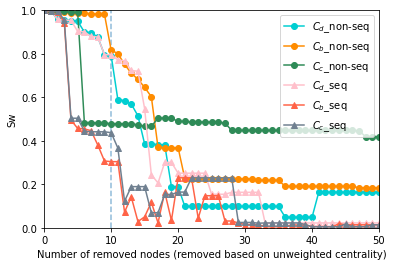

In [34]:
p_label=[
    '${C_b}$_non-seq',
    '${C_c}$_non-seq',
    '${C_d}$_non-seq',
    '${C_b}$_seq',
    '${C_c}$_seq',
    '${C_d}$_seq'
]

plt.xlabel('Number of removed nodes (removed based on unweighted centrality)')
plt.ylabel('Sw')
plt.xlim(xmax=50,xmin=0)
plt.ylim(ymax=1,ymin=0)

x = range(0,306)

y1 = score_b_1
y2 = score_b_2
y3 = score_b_3
y4 = score_b_4
y5 = score_b_5
y6 = score_b_6

plt.plot([10,10],[0,1],'--',alpha=0.5)

plt.plot(x, y3,'o-', color='#00CED1',label=p_label[2])
plt.plot(x, y1,'o-', color='darkorange',label=p_label[0])
plt.plot(x, y2,'o-', color='seagreen', label=p_label[1])

plt.plot(x, y6,'^-', color='pink', label=p_label[5])
plt.plot(x, y4,'^-', color='tomato',label=p_label[3])
plt.plot(x, y5,'^-', color='slategray', label=p_label[4])


plt.legend()
plt.savefig('Figure2a.png', dpi=600)
plt.show()

## Recompute the centrality

In this part, considering the flow as weight, we can recompute the centrality (use the flow as weight) and got the new results of removal in 6 scenarios.

In [35]:
g_shp_3=g_flows.to_undirected()

We need to inverse the weight value to calculate the centrality.

In [36]:
new_weight={}

for e1,e2,c in g_shp_3.edges(data='weight'):
    new_weight[(e1,e2)]=1/c

nx.set_edge_attributes(g_shp_3,new_weight,'new_weight')

nx.to_pandas_edgelist(g_shp_3)

,source,target,weight,new_weight
0,0,1,15035.0,0.000067
1,0,2,19675.0,0.000051
2,0,33,110221.0,0.000009
3,0,75,91546.0,0.000011
4,0,76,77262.0,0.000013
...,...,...,...,...
307,267,268,6582.0,0.000152
308,269,270,27685.0,0.000036
309,269,271,21126.0,0.000047
310,270,274,36909.0,0.000027


### Degree

In [37]:
degree=g_shp_3.degree(weight='new_weight')
nx.set_node_attributes(g_shp_3,dict(degree),'degree')

# non-seq
degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
node3=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
max_3=node3[0:10]

degree_df.sort_values('degree',axis = 0,ascending = False)

,degree
259,0.011682
258,0.011211
41,0.008489
51,0.007836
142,0.005900
...,...
282,0.000000
145,0.000000
284,0.000000
285,0.000000


In [38]:
# seq
max_6=[]
g_6=g_shp_3.copy()
for i in range(0,10):
    degree=g_6.degree(weight='new_weight')
    nx.set_node_attributes(g_6,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    max_6.append(node6[0])
    g_6.remove_nodes_from([node6[0]])

### Betweenness

In [39]:
bet_london_w=nx.betweenness_centrality(g_shp_3, weight='new_weight', normalized=False)
nx.set_node_attributes(g_shp_3,bet_london_w,'betweenness_w')

# non-seq
betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
max_1=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)[0:10]

betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False)

,betweenness_w
155,22264.0
33,13542.0
10,13371.0
0,13224.0
25,13035.0
...,...
231,0.0
229,0.0
161,0.0
162,0.0


In [40]:
# seq
max_4=[]
g_4=g_shp_3.copy()

for i in range(0,10):
    bet_london_w=nx.betweenness_centrality(g_4, weight='new_weight', normalized=False)
    nx.set_node_attributes(g_4,bet_london_w,'betweenness_w')
    betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
    max_4.append(node4[0])
    g_4.remove_nodes_from([node4[0]])

### Closeness

In [41]:
closeness_w=nx.closeness_centrality(g_shp_3,distance='new_weight')
nx.set_node_attributes(g_shp_3,closeness_w,'closeness_w')

# non-seq
closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
max_2=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)[0:10]

closeness_df.sort_values('closeness_w',axis = 0,ascending = False)

,closeness_w
155,2771.732272
86,2752.458675
33,2750.389209
24,2741.192956
10,2739.190189
...,...
281,0.000000
282,0.000000
283,0.000000
284,0.000000


In [42]:
# seq
max_5=[]
g_5=g_shp_3.copy()
for i in range(0,10):
    closeness_w=nx.closeness_centrality(g_5,distance='new_weight')
    nx.set_node_attributes(g_5,closeness_w,'closeness_w')
    closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
    node5=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
    max_5.append(node5[0])
    g_5.remove_nodes_from([node5[0]])

Output the new importance order of stations.

In [43]:
importance=pd.DataFrame(index=range(0,10),columns=['Betweenness(non-seq)','Closeness(non-seq)','Degree(non-seq)','Betweenness(seq)','Closeness(seq)','Degree(seq)'])

In [44]:
columns=['Betweenness(non-seq)','Closeness(non-seq)','Degree(non-seq)','Betweenness(seq)','Closeness(seq)','Degree(seq)']
max_all=[max_1,max_2,max_3,max_4,max_5,max_6]
for i in range(0,6):
    for j in range(0,10):
        importance[columns[i]][j]=g_shp_un.nodes[max_all[i][j]]['station']
importance.insert(0,'Rank',range(1,11))  

In [45]:
importance.to_csv('New importance.csv')

Use the new orders to re-evaluate the impact of each attack strategy

In [46]:
################  non-seq  #################

# betweenness non-seq
bet_london_w=nx.betweenness_centrality(g_shp_3,weight='new_weight', normalized=False)
betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
node1=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
score_b_1=[]
g_1=g_shp_3.copy()
for i in range(0,len(list(g_shp_3.nodes))):
    score_b_1.append(rsmcs_weight(g_1))
    g_1.remove_nodes_from([node1[i]])

# closeness non-seq
closeness_w=nx.closeness_centrality(g_shp_3,distance='new_weight')
closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
node2=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
score_b_2=[]
g_2=g_shp_3.copy()
for i in range(0,len(list(g_shp_3.nodes))):
    score_b_2.append(rsmcs_weight(g_2))
    g_2.remove_nodes_from([node2[i]])

# degree non-seq
degree=g_shp_3.degree(weight='new_weight')
degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
node3=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
score_b_3=[]
g_3=g_shp_3.copy()
for i in range(0,len(list(g_shp_3.nodes))):
    score_b_3.append(rsmcs_weight(g_3))
    g_3.remove_nodes_from([node3[i]])

    
##################      seq    ########################

#betweenness seq
score_b_4=[]
g_4=g_shp_3.copy()
for i in range(0,len(list(g_shp_3.nodes))):
    score_b_4.append(rsmcs_weight(g_4))
    bet_london_w=nx.betweenness_centrality(g_4, weight='new_weight',normalized=False)
    nx.set_node_attributes(g_4,bet_london_w,'betweenness_w')
    betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
    g_4.remove_nodes_from([node4[0]])

# closeness seq
score_b_5=[]
g_5=g_shp_3.copy()
for i in range(0,len(list(g_shp_3.nodes))):
    score_b_5.append(rsmcs_weight(g_5))
    closeness_w=nx.closeness_centrality(g_5,distance='new_weight')
    nx.set_node_attributes(g_5,closeness_w,'closeness_w')
    closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
    node5=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
    g_5.remove_nodes_from([node5[0]])
    
# degree seq
score_b_6=[]
g_6=g_shp_3.copy()
for i in range(0,len(list(g_shp_3.nodes))):
    score_b_6.append(rsmcs_weight(g_6))
    degree=g_6.degree(weight='new_weight')
    nx.set_node_attributes(g_6,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    g_6.remove_nodes_from([node6[0]])

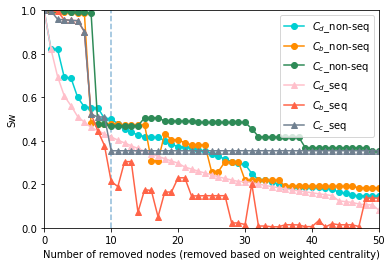

In [47]:
plt.xlabel('Number of removed nodes (removed based on weighted centrality)')
plt.ylabel('Sw')
plt.xlim(xmax=50,xmin=0)
plt.ylim(ymax=1,ymin=0)

x = range(0,306)

y1 = score_b_1
y2 = score_b_2
y3 = score_b_3
y4 = score_b_4
y5 = score_b_5
y6 = score_b_6

plt.plot([10,10],[0,1],'--',alpha=0.5)

plt.plot(x, y3,'o-', color='#00CED1',label=p_label[2])
plt.plot(x, y1,'o-', color='darkorange',label=p_label[0])
plt.plot(x, y2,'o-', color='seagreen', label=p_label[1])

plt.plot(x, y6,'^-', color='pink', label=p_label[5])
plt.plot(x, y4,'^-', color='tomato',label=p_label[3])
plt.plot(x, y5,'^-', color='slategray', label=p_label[4])


plt.legend()
plt.savefig('Figure2b.png', dpi=600)
plt.show()

## SI model

### Flows data

In [174]:
flows=nx.to_pandas_edgelist(g_OD)
flows.rename(columns={'source':'Orig'},inplace=True)
flows.rename(columns={'target':'Dest'},inplace=True)
flows.rename(columns={'total_wtrips':'Flows'},inplace=True)
flows.sort_values(by=['Orig','Dest'],inplace=True)
flows

,Orig,Dest,Flows
905,0,1,35
827,0,3,290
854,0,4,73
923,0,5,744
850,0,6,6
...,...,...,...
31351,276,271,1043
31185,276,272,1437
31242,276,273,1232
31312,276,274,761


### Population and jobs data

We also need the population data ,the numbers of jobs for each stations, and the distance data.

We will use the out flows from origins as population, and in flows at destination as jobs.

In [175]:
data=pd.DataFrame(index=range(0,277))
data['Pop']=0
data['Job']=0
for i in range(0,277):
    for j in range(0,len(flows)):
        if flows.Orig[j]==i:data.Pop[i]=data.Pop[i]+flows.Flows[j]
        if flows.Dest[j]==i:data.Job[i]=data.Job[i]+flows.Flows[j]

In [177]:
data

,Pop,Job
0,24582,26836
1,12576,12652
2,3128,3965
3,15330,17958
4,15961,21813
...,...,...
272,33326,24288
273,39129,34594
274,27564,28290
275,10695,10049


In [178]:
flows=flows.merge(data,left_on="Orig",right_on=data.index)
flows.drop(columns='Job',inplace=True)
flows.rename(columns={'Pop':'Population'},inplace=True)

flows=flows.merge(data,left_on="Dest",right_on=data.index)
flows.drop(columns='Pop',inplace=True)
flows.rename(columns={'Job':'Jobs'},inplace=True)

flows

,Orig,Dest,Flows,Population,Jobs
0,0,1,35,24582,12652
1,2,1,43,3128,12652
2,3,1,623,15330,12652
3,4,1,283,15961,12652
4,5,1,454,21228,12652
...,...,...,...,...,...
33924,155,42,22,27042,313
33925,156,42,0,53207,313
33926,214,42,0,14139,313
33927,215,42,30,33973,313


### Distance data

We have the population and jobs data now. Get the distance data from `g_shp_un`.

In [179]:
dist=np.zeros((len(g_shp_un.nodes()),len(g_shp_un.nodes())))

for i in range(0,len(g_shp_un.nodes())):
    for j in range(0,len(g_shp_un.nodes())):
        n=nx.shortest_path_length(g_shp_un,source=i,target=j,weight='distance')
        dist[i,j]=n

In [180]:
dist

array([[    0.        ,   416.58605041,   734.17363616, ...,
         8863.06747092,  9817.4155055 ,  8998.91918006],
       [  416.58605041,     0.        ,  1150.75968657, ...,
         9279.65352133, 10234.00155591,  9415.50523047],
       [  734.17363616,  1150.75968657,     0.        , ...,
         8230.24559787,  9184.59363245,  8366.09730701],
       ...,
       [ 8863.06747092,  9279.65352133,  8230.24559787, ...,
            0.        ,   954.34803458,  2416.81311282],
       [ 9817.4155055 , 10234.00155591,  9184.59363245, ...,
          954.34803458,     0.        ,  3371.1611474 ],
       [ 8998.91918006,  9415.50523047,  8366.09730701, ...,
         2416.81311282,  3371.1611474 ,     0.        ]])

In [181]:
flows['Dist']=0
for a in range(0,len(flows)):
    for i in range(0,len(g_shp_un.nodes())):
        if flows['Orig'][a]==i:
            for j in range(0,len(g_shp_un.nodes())):
                 if flows['Dest'][a]==j: flows['Dist'][a]=dist[i,j]

In [182]:
flows

,Orig,Dest,Flows,Population,Jobs,Dist
0,0,1,35,24582,12652,416
1,2,1,43,3128,12652,1150
2,3,1,623,15330,12652,3507
3,4,1,283,15961,12652,3686
4,5,1,454,21228,12652,2817
...,...,...,...,...,...,...
33924,155,42,22,27042,313,20573
33925,156,42,0,53207,313,14088
33926,214,42,0,14139,313,21198
33927,215,42,30,33973,313,19827


### The model and its calibration

Now, we can use the dataframe to model our spatial interaction model.

For we will investigate the impact of the decrease in the number of jobs(destination attractive), I chose to use the production-constrained model.

In [183]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import geopandas as gpd
import seaborn as sns
import folium
import numpy as np
from math import sqrt

In [184]:
cdatasubmat=pd.pivot_table(flows,values='Flows',index='Orig',columns='Dest',aggfunc=np.sum,margins=True)
cdatasubmat

Dest,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,All
Orig,,,,,,,,,,,,,,,,,,,,,
0,NaN,35.0,NaN,290.0,73.0,744.0,6.0,177.0,63.0,12.0,...,NaN,NaN,22.0,168.0,33.0,156.0,71.0,0.0,202.0,24582
1,137.0,NaN,31.0,509.0,802.0,314.0,0.0,662.0,142.0,48.0,...,NaN,19.0,6.0,24.0,270.0,12.0,93.0,12.0,77.0,12576
2,0.0,43.0,NaN,218.0,56.0,131.0,3.0,302.0,123.0,28.0,...,NaN,NaN,NaN,43.0,62.0,0.0,NaN,NaN,54.0,3128
3,255.0,623.0,312.0,NaN,14.0,300.0,263.0,1245.0,146.0,76.0,...,8.0,100.0,64.0,170.0,83.0,285.0,329.0,0.0,NaN,15330
4,0.0,283.0,52.0,92.0,NaN,109.0,68.0,179.0,84.0,29.0,...,NaN,17.0,173.0,5.0,139.0,2.0,3.0,73.0,1.0,15961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,117.0,5.0,6.0,414.0,74.0,249.0,0.0,477.0,115.0,79.0,...,NaN,225.0,781.0,1211.0,922.0,NaN,2033.0,422.0,1418.0,39129
274,269.0,47.0,3.0,196.0,122.0,145.0,NaN,168.0,267.0,120.0,...,NaN,181.0,70.0,512.0,613.0,2143.0,NaN,257.0,960.0,27564
275,12.0,119.0,11.0,32.0,52.0,140.0,78.0,128.0,0.0,10.0,...,NaN,67.0,164.0,167.0,112.0,220.0,298.0,NaN,223.0,10695


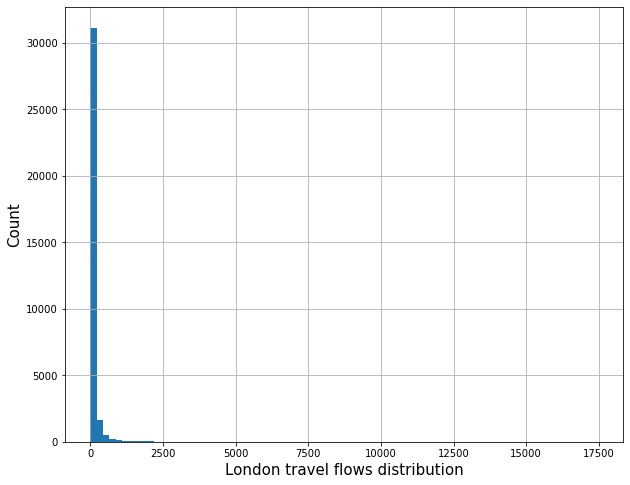

In [220]:
# see the distribution of flows
plt.subplots(figsize=(10,8))

plt.hist(flows["Flows"], histtype="stepfilled" , bins = 80)
plt.xlabel("London travel flows distribution", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.grid(True)
plt.savefig('Figure3.png', dpi=600)
plt.show()

In [227]:
flows.describe()

,Orig,Dest,Flows,Population,Jobs,Dist,log_Population,log_Jobs,log_Dist,O_i,D_j,alpha_i,prodsimest1,Job_scenario_A,prodsimest2
count,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000,33929.000000
mean,135.791447,134.379616,83.717321,14568.070942,15990.423001,13858.885172,9.106114,9.104723,9.318687,14568.070942,15990.423001,1.732673,83.715966,15755.529871,83.718324
std,83.136172,82.935180,260.112865,16975.072462,19404.916003,8285.314912,0.962515,1.076851,0.732657,16975.072462,19404.916003,0.690318,145.265073,18973.846756,141.660270
min,0.000000,0.000000,0.000000,549.000000,313.000000,179.000000,6.308098,5.746203,5.187386,549.000000,313.000000,0.133006,1.000000,313.000000,0.000000
25%,65.000000,65.000000,6.000000,4496.000000,4092.000000,7454.000000,8.410943,8.316789,8.916506,4496.000000,4092.000000,1.252225,21.000000,4092.000000,19.000000
50%,130.000000,125.000000,23.000000,8373.000000,8584.000000,12697.000000,9.032768,9.057655,9.449121,8373.000000,8584.000000,1.650065,42.000000,8584.000000,42.000000
75%,211.000000,210.000000,74.000000,16650.000000,19875.000000,18809.000000,9.720165,9.897218,9.842091,16650.000000,19875.000000,2.155151,88.000000,19875.000000,90.000000
max,276.000000,276.000000,17462.000000,94513.000000,99997.000000,55407.000000,11.456493,11.512895,10.922461,94513.000000,99997.000000,3.835162,3669.000000,99997.000000,2878.000000


In [229]:
flows.describe().to_csv('The descriptive statistics of variables.csv')

In [185]:
#take the variables and produce logarithms of them
x_variables = ["Population", "Jobs", "Dist"]
log_x_vars = []
for x in x_variables:
    flows[f"log_{x}"] = np.log(flows[x])
    log_x_vars.append(f"log_{x}")

In [186]:
# create a str variable of origin and dest
flows['OrigCode']='a'
flows['DestCode']='a'
for i in range(0,len(flows)):
    flows['OrigCode'][i] ='Code'+str(flows['Orig'][i])
    flows['DestCode'][i] ='Dest'+str(flows['Dest'][i])

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [187]:
flows

,Orig,Dest,Flows,Population,Jobs,Dist,log_Population,log_Jobs,log_Dist,OrigCode,DestCode
0,0,1,35,24582,12652,416,10.109770,9.445571,6.030685,Code0,Dest1
1,2,1,43,3128,12652,1150,8.048149,9.445571,7.047517,Code2,Dest1
2,3,1,623,15330,12652,3507,9.637567,9.445571,8.162516,Code3,Dest1
3,4,1,283,15961,12652,3686,9.677904,9.445571,8.212297,Code4,Dest1
4,5,1,454,21228,12652,2817,9.963076,9.445571,7.943428,Code5,Dest1
...,...,...,...,...,...,...,...,...,...,...,...
33924,155,42,22,27042,313,20573,10.205146,5.746203,9.931735,Code155,Dest42
33925,156,42,0,53207,313,14088,10.881945,5.746203,9.553079,Code156,Dest42
33926,214,42,0,14139,313,21198,9.556692,5.746203,9.961662,Code214,Dest42
33927,215,42,30,33973,313,19827,10.433321,5.746203,9.894800,Code215,Dest42


In [230]:
formula = 'Flows ~ OrigCode + log_Jobs + log_Dist-1'
prodSim = smf.glm(formula = formula, data=flows, family=sm.families.Poisson()).fit()

In [192]:
flows['prodsimest1']=np.round(prodSim1.predict(),0)
cdatasubmat1 = flows.pivot_table(values ="prodsimest1", index="Orig", columns = "Dest",aggfunc=np.sum, margins=True)

How good the fits?

In [201]:
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)   
    return RMSE

def HowGood(observed, estimated):
    '''
    This function returen the results of RSquared and RMSE
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values
    '''
    print(f'The RSquared is: '+str(CalcRSqaured(observed,estimated)))
    print(f'The RMSE is: '+str(CalcRMSE(observed,estimated)))

In [202]:
HowGood(flows["Flows"],flows["prodsimest1"])

The RSquared is: 0.3757031413851896
The RMSE is: 206.006


Let's try anthor distance function to see if the fit will be better.

The negative exponential:

$f(c_{ij})=c_{ij}^{-\beta}$

The inverse power:

$f(c_{ij})=exp(- \beta c_{ij})$

In [207]:
formula = 'Flows ~ OrigCode + log_Jobs + Dist-1'
prodSim2 = smf.glm(formula = formula, data=flows, family=sm.families.Poisson()).fit()

In [208]:
flows['prodsimest2']=np.round(prodSim2.predict(),0)

In [260]:
cdatasubmat2 = flows.pivot_table(values ="prodsimest2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

Dest,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,All
Orig,,,,,,,,,,,,,,,,,,,,,
0,NaN,226.0,NaN,234.0,264.0,364.0,107.0,508.0,173.0,56.0,...,NaN,NaN,92.0,115.0,202.0,324.0,195.0,143.0,281.0,24584.0
1,209.0,NaN,53.0,125.0,141.0,195.0,61.0,289.0,92.0,30.0,...,NaN,34.0,49.0,62.0,108.0,173.0,104.0,77.0,150.0,12573.0
2,70.0,41.0,NaN,47.0,53.0,73.0,19.0,92.0,35.0,11.0,...,NaN,NaN,NaN,21.0,39.0,59.0,NaN,NaN,54.0,3129.0
3,191.0,110.0,54.0,NaN,207.0,257.0,52.0,248.0,135.0,44.0,...,8.0,38.0,55.0,69.0,142.0,195.0,117.0,94.0,NaN,15338.0
4,190.0,110.0,54.0,182.0,NaN,256.0,52.0,247.0,138.0,45.0,...,NaN,38.0,55.0,69.0,145.0,194.0,117.0,97.0,189.0,15964.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,509.0,294.0,130.0,376.0,423.0,554.0,140.0,663.0,277.0,90.0,...,NaN,168.0,242.0,305.0,291.0,NaN,516.0,206.0,404.0,39130.0
274,352.0,204.0,90.0,260.0,293.0,384.0,NaN,459.0,192.0,62.0,...,NaN,247.0,355.0,447.0,201.0,593.0,NaN,143.0,280.0,27563.0
275,124.0,72.0,34.0,100.0,116.0,154.0,34.0,161.0,80.0,26.0,...,NaN,22.0,32.0,40.0,124.0,114.0,68.0,NaN,172.0,10688.0


In [209]:
HowGood(flows["Flows"],flows["prodsimest2"])

The RSquared is: 0.40134575676936174
The RMSE is: 202.578


Better!

But what if we use unconstrained model?

In [237]:
# The inverse power
formula = 'Flows ~ log_Population + log_Jobs + Dist-1'
prodSim3 = smf.glm(formula = formula, data=flows, family=sm.families.Poisson()).fit()
flows['prodsimest3']=np.round(prodSim3.predict(),0)
HowGood(flows["Flows"],flows["prodsimest3"])

The RSquared is: 0.20905009241512676
The RMSE is: 235.261


In [238]:
#The negative exponential
formula = 'Flows ~ log_Population + log_Jobs + log_Dist-1'
prodSim4 = smf.glm(formula = formula, data=flows, family=sm.families.Poisson()).fit()
flows['prodsimest4']=np.round(prodSim4.predict(),0)
HowGood(flows["Flows"],flows["prodsimest4"])

The RSquared is: 0.2589853666053922
The RMSE is: 224.162


The second is the best. Now we print the regression result.

In [231]:
print(prodSim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Flows   No. Observations:                33929
Model:                            GLM   Df Residuals:                    33663
Model Family:                 Poisson   Df Model:                          265
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7105e+06
Date:                Sun, 25 Apr 2021   Deviance:                   3.2673e+06
Time:                        15:04:05   Pearson chi2:                 4.85e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OrigCode[Code0]      -1.0220      0.00

In [247]:
# we can extract these parameters
coefs = pd.DataFrame(prodSim2.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(OrigCode)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

coefs

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,coef,alpha_i
0,Code0,-1.022037
1,Code1,-1.616394
2,Code10,0.234124
3,Code100,-1.800439
4,Code101,-0.653926
...,...,...
261,Code97,-0.288332
262,Code98,-0.710332
263,Code99,-1.897085
264,log_Jobs,0.685302


In [248]:
#save them
coefs.to_csv('Table 4 The result of parameter calibration.csv')

In [252]:
# since we will use them to estimate the flows, we can also merge it into the initial dataframe
flows = flows.merge(coefs, left_on="OrigCode", right_on="coef", how = "left")
flows.drop(columns = ["coef"], inplace = True)
#check this has worked
flows.head()

,Orig,Dest,Flows,Population,Jobs,Dist,log_Population,log_Jobs,log_Dist,OrigCode,DestCode,prodsimest1,Job_scenario_A,prodsimest2,prodsimest3,prodsimest4,alpha_i
0,0,1,35,24582,12652,416,10.109770,9.445571,6.030685,Code0,Dest1,450.0,12652.0,226.0,288.0,796.0,-1.022037
1,2,1,43,3128,12652,1150,8.048149,9.445571,7.047517,Code2,Dest1,53.0,12652.0,41.0,154.0,143.0,-2.677420
2,3,1,623,15330,12652,3507,9.637567,9.445571,8.162516,Code3,Dest1,94.0,12652.0,110.0,192.0,168.0,-1.502179
3,4,1,283,15961,12652,3686,9.677904,9.445571,8.212297,Code4,Dest1,94.0,12652.0,110.0,192.0,167.0,-1.493543
4,5,1,454,21228,12652,2817,9.963076,9.445571,7.943428,Code5,Dest1,133.0,12652.0,144.0,224.0,229.0,-1.285361


In [257]:
alpha_i = prodSim2.params[0:-2]
gamma = prodSim2.params[-2]
beta = prodSim2.params[-1]

## Scenario A

Scenario A: assume that Canary Wharf has a 50% decrease in jobs after Brexit.

Scenario B: assume that there is a significant increase in the cost of transport. 

Using the calibrated parameter beta, compute the new flows for scenario A.
Select 2 values for the parameter in the cost function reflecting scenario B.
 
Using plots, comment on the change in flows for the different stations given the 3 different situations (scenario A, and scenario B with two selections of parameters). 
Which scenario would have more impact for the redistribution of flows?
Explain and justify your answers using the results of the analysis. 

In [196]:
# find the ID of Canary Wharf 
nx.to_pandas_edgelist(g_shp_un)[nx.to_pandas_edgelist(g_shp_un)['station_1_']=='Canary Wharf']

,source,target,station_1,station_1_,toid_seq,ShpName,station_2_,station_2,distance
211,156,157,42,Canary Wharf,203,underground,North Greenwich,183,1796.461960
212,156,289,42,Canary Wharf,385,underground,Heron Quays,120,204.551615
213,156,290,42,Canary Wharf,386,underground,West India Quay,292,215.455867


In [254]:
# find how many jobs Canary Wharf originally have
job=list(flows[flows.Dest==156]['Jobs'])[0]
# now calculate what number it is to change to
job_new=job*0.5
job_new

34058.5

In [199]:
def new_sal(row):
    if row["Dest"] == 156: val = 34058.5
    else: val = row["Jobs"]
    return val
        
flows["Job_scenario_A"] = flows.apply(new_sal, axis =1)
flows[flows.Dest==156]

,Orig,Dest,Flows,Population,Jobs,Dist,log_Population,log_Jobs,log_Dist,OrigCode,DestCode,O_i,D_j,alpha_i,prodsimest1,Job_scenario_A
16453,0,156,848,24582,68117,10557,10.109770,11.128982,9.264544,Code0,Dest156,24582,68117,2.264441,324.0,34058.5
16454,1,156,193,12576,68117,10974,9.439546,11.128982,9.303284,Code1,Dest156,12576,68117,1.679352,177.0,34058.5
16455,2,156,29,3128,68117,9924,8.048149,11.128982,9.202711,Code2,Dest156,3128,68117,0.595649,63.0,34058.5
16456,3,156,132,15330,68117,7708,9.637567,11.128982,8.950014,Code3,Dest156,15330,68117,1.698726,213.0,34058.5
16457,4,156,104,15961,68117,7529,9.677904,11.128982,8.926518,Code4,Dest156,15961,68117,1.726826,222.0,34058.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16682,272,156,454,33326,68117,10599,10.414093,11.128982,9.268515,Code272,Dest156,33326,68117,2.777081,540.0,34058.5
16683,273,156,412,39129,68117,10799,10.574619,11.128982,9.287209,Code273,Dest156,39129,68117,2.938292,628.0,34058.5
16684,274,156,68,27564,68117,15640,10.224266,11.128982,9.657587,Code274,Dest156,27564,68117,2.863505,490.0,34058.5
16685,275,156,487,10695,68117,10208,9.277532,11.128982,9.230927,Code275,Dest156,10695,68117,1.467694,148.0,34058.5


Now we can use the new job data to predict the flow based on the parameters estimated above.

In [264]:
flows["prodsimest5"] = np.exp(flows["alpha_i"]+gamma*np.log(flows["Job_scenario_A"]) + beta*flows["Dist"])
flows["prodsimest5"] = round(flows["prodsimest5"],0)
cdatasubmat5 = flows.pivot_table(values ="prodsimest5", index="Orig", columns = "Dest",aggfunc=np.sum, margins=True)
cdatasubmat5

Dest,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,All
Orig,,,,,,,,,,,,,,,,,,,,,
0,NaN,226.0,NaN,234.0,264.0,364.0,107.0,508.0,173.0,56.0,...,NaN,NaN,92.0,115.0,202.0,324.0,195.0,143.0,281.0,24459.0
1,209.0,NaN,53.0,125.0,141.0,195.0,61.0,289.0,92.0,30.0,...,NaN,34.0,49.0,62.0,108.0,173.0,104.0,77.0,150.0,12507.0
2,70.0,41.0,NaN,47.0,53.0,73.0,19.0,92.0,35.0,11.0,...,NaN,NaN,NaN,21.0,39.0,59.0,NaN,NaN,54.0,3104.0
3,191.0,110.0,54.0,NaN,207.0,257.0,52.0,248.0,135.0,44.0,...,8.0,38.0,55.0,69.0,142.0,195.0,117.0,94.0,NaN,15242.0
4,190.0,110.0,54.0,182.0,NaN,256.0,52.0,247.0,138.0,45.0,...,NaN,38.0,55.0,69.0,145.0,194.0,117.0,97.0,189.0,15866.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,509.0,294.0,130.0,376.0,423.0,554.0,140.0,663.0,277.0,90.0,...,NaN,168.0,242.0,305.0,291.0,NaN,516.0,206.0,404.0,38901.0
274,352.0,204.0,90.0,260.0,293.0,384.0,NaN,459.0,192.0,62.0,...,NaN,247.0,355.0,447.0,201.0,593.0,NaN,143.0,280.0,27405.0
275,124.0,72.0,34.0,100.0,116.0,154.0,34.0,161.0,80.0,26.0,...,NaN,22.0,32.0,40.0,124.0,114.0,68.0,NaN,172.0,10632.0


In [263]:
cdatasubmat

Dest,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,All
Orig,,,,,,,,,,,,,,,,,,,,,
0,NaN,35.0,NaN,290.0,73.0,744.0,6.0,177.0,63.0,12.0,...,NaN,NaN,22.0,168.0,33.0,156.0,71.0,0.0,202.0,24582
1,137.0,NaN,31.0,509.0,802.0,314.0,0.0,662.0,142.0,48.0,...,NaN,19.0,6.0,24.0,270.0,12.0,93.0,12.0,77.0,12576
2,0.0,43.0,NaN,218.0,56.0,131.0,3.0,302.0,123.0,28.0,...,NaN,NaN,NaN,43.0,62.0,0.0,NaN,NaN,54.0,3128
3,255.0,623.0,312.0,NaN,14.0,300.0,263.0,1245.0,146.0,76.0,...,8.0,100.0,64.0,170.0,83.0,285.0,329.0,0.0,NaN,15330
4,0.0,283.0,52.0,92.0,NaN,109.0,68.0,179.0,84.0,29.0,...,NaN,17.0,173.0,5.0,139.0,2.0,3.0,73.0,1.0,15961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,117.0,5.0,6.0,414.0,74.0,249.0,0.0,477.0,115.0,79.0,...,NaN,225.0,781.0,1211.0,922.0,NaN,2033.0,422.0,1418.0,39129
274,269.0,47.0,3.0,196.0,122.0,145.0,NaN,168.0,267.0,120.0,...,NaN,181.0,70.0,512.0,613.0,2143.0,NaN,257.0,960.0,27564
275,12.0,119.0,11.0,32.0,52.0,140.0,78.0,128.0,0.0,10.0,...,NaN,67.0,164.0,167.0,112.0,220.0,298.0,NaN,223.0,10695


In [265]:
flows

,Orig,Dest,Flows,Population,Jobs,Dist,log_Population,log_Jobs,log_Dist,OrigCode,DestCode,prodsimest1,Job_scenario_A,prodsimest2,prodsimest3,prodsimest4,alpha_i,prodsimest5
0,0,1,35,24582,12652,416,10.109770,9.445571,6.030685,Code0,Dest1,450.0,12652.0,226.0,288.0,796.0,-1.022037,226.0
1,2,1,43,3128,12652,1150,8.048149,9.445571,7.047517,Code2,Dest1,53.0,12652.0,41.0,154.0,143.0,-2.677420,41.0
2,3,1,623,15330,12652,3507,9.637567,9.445571,8.162516,Code3,Dest1,94.0,12652.0,110.0,192.0,168.0,-1.502179,110.0
3,4,1,283,15961,12652,3686,9.677904,9.445571,8.212297,Code4,Dest1,94.0,12652.0,110.0,192.0,167.0,-1.493543,110.0
4,5,1,454,21228,12652,2817,9.963076,9.445571,7.943428,Code5,Dest1,133.0,12652.0,144.0,224.0,229.0,-1.285361,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33924,155,42,22,27042,313,20573,10.205146,5.746203,9.931735,Code155,Dest42,5.0,313.0,4.0,15.0,11.0,-0.984654,4.0
33925,156,42,0,53207,313,14088,10.881945,5.746203,9.553079,Code156,Dest42,17.0,313.0,18.0,33.0,20.0,0.009051,18.0
33926,214,42,0,14139,313,21198,9.556692,5.746203,9.961662,Code214,Dest42,3.0,313.0,2.0,12.0,8.0,-1.509772,2.0
33927,215,42,30,33973,313,19827,10.433321,5.746203,9.894800,Code215,Dest42,7.0,313.0,5.0,18.0,13.0,-0.749028,5.0


### Visualize the change of flows

In [411]:
import geopandas as gpd
import gzip
import os

In [393]:
EW = gpd.read_file('Local_Authority_Districts_(December_2015)_Boundaries.geojson')

In [432]:
London = EW[EW.lad15cd.str.contains("E09")]

Now, we need two gragh: one draws the change of the in-flow, the other draws the change of the out-flow.

In [403]:
from matplotlib.pyplot import figure

In [663]:
# select the id 156
flows_A_1=flows[flows.Orig==156][['Orig','Dest','Flows','Jobs','prodsimest5','Dist']]
flows_A_2=flows[flows.Dest==156][['Orig','Dest','Flows','Population','prodsimest5','Dist']]

In [833]:
def CreateGraph(flows_A_1):
    '''
    This function use to create the graph beasd on the dataframe
    and add the coordinates and names of stations
    and plot
    and save to local
    '''
    
    #calculate the change
    flows_A_1['Change']=0
    flows_A_1['Change']=flows_A_1['prodsimest5']-flows_A_1['Flows']
    flows_A_1['Change_decrease']=0
    
    for i in flows_A_1.index:
        if flows_A_1.Change[i]<0:
            flows_A_1['Change_decrease'][i]=flows_A_1.Change[i]*(-1)
            flows_A_1.Change[i]=0
        else:
            flows_A_1['Change_decrease'][i]=0
            
    g1=nx.from_pandas_edgelist(flows_A_1, 'Orig', 'Dest',['Change'],create_using=nx.MultiGraph)
    g2=nx.from_pandas_edgelist(flows_A_1, 'Orig', 'Dest',['Change_decrease'],create_using=nx.MultiGraph)
    
    nx.set_node_attributes(g1,nod_coords,'station_coord') 
    pos = {e1: xy for e1,xy in g1.nodes(data='station_coord')}
    nx.set_node_attributes(g2,nod_coords,'station_coord') 
    pos = {e1: xy for e1,xy in g2.nodes(data='station_coord')}

    nx.set_node_attributes(g1,nod_names,'station')
    nx.set_node_attributes(g2,nod_names,'station')
    
    weights1 = [w for e1,e2,w in g1.edges(data='Change')]
    weights2 = [w for e1,e2,w in g2.edges(data='Change')]

    weights_size1=[(w/max(weights)*10) for e1,e2,w in g1.edges(data='Change')]
    weights_size2=[(w/max(weights)*10) for e1,e2,w in g2.edges(data='Change_decrease')]


    figure(figsize=(12, 12))
    ax = London.plot(linewidth=1, edgecolor="black", facecolor="grey",figsize=(12,12),alpha=0.1)


    nx.draw_networkx_nodes(g_shp_un,
            pos = {e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')},
            ax=ax,
            node_color= 'grey',
            node_size= 1)


    nx.draw_networkx_edges(g2, pos,ax=ax,edge_color='#00CED1', width=weights_size2,label="Decrease")
    nx.draw_networkx_edges(g1, pos,ax=ax,edge_color='tomato', width=weights_size1,label="Increase")

    x, y, arrow_length = 0.9, 1, 0.12
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

    plt.axis("off")
    plt.legend(fontsize=12,loc=(0.83,0.2))

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 864x864 with 0 Axes>

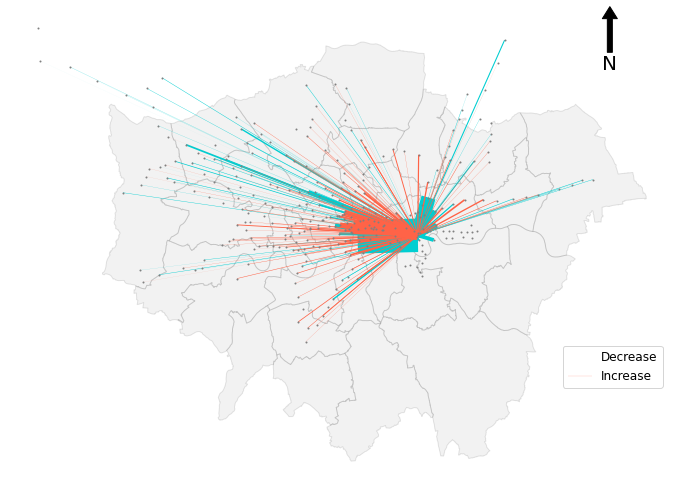

In [905]:
# let's see the change of the flows that regared this place as origin (i.e. passengers go to other place from this place)
CreateGraph(flows_A_1)
plt.savefig('Figure4b_outflow.png',dpi=600)
plt.show()

In [776]:
NameDF = pd.DataFrame(StationNames,columns=['Station_Name'])
a=flows_A_1.merge(NameDF,left_on='Dest',right_on=NameDF.index,how='left')

In [778]:
a_1=a.sort_values('Change',axis = 0,ascending = False)
a_2=a.sort_values('Change_decrease',axis = 0,ascending = False)

In [785]:
'''
x = np.arange(10)# the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.barh(x - width/2, a_1.prodsimest5[0:10], width, label='New flows')
rects2 = ax.barh(x + width/2, a_1.Flows[0:10], width, label='Initial flows')
ax.legend()
ax.set_yticks(x)
ax.set_yticklabels(list(a_1.station_1_[0:10]))
plt.grid()
plt.savefig('Orign_increse.png',dpi=600)
plt.show()
'''

"\nx = np.arange(10)# the label locations\nwidth = 0.35  # the width of the bars\nfig, ax = plt.subplots(figsize=(8, 5))\nrects1 = ax.barh(x - width/2, a_1.prodsimest5[0:10], width, label='New flows')\nrects2 = ax.barh(x + width/2, a_1.Flows[0:10], width, label='Initial flows')\nax.legend()\nax.set_yticks(x)\nax.set_yticklabels(list(a_1.station_1_[0:10]))\nplt.grid()\nplt.savefig('Orign_increse.png',dpi=600)\nplt.show()\n"

In [786]:
'''
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.barh(x - width/2, a_2.prodsimest5[0:10], width, label='New flows')
rects2 = ax.barh(x + width/2, a_2.Flows[0:10], width, label='Initial flows')
ax.legend()
ax.set_yticks(x)
ax.set_yticklabels(list(a_2.station_1_[0:10]))
plt.grid()
plt.savefig('Orign_decrease.png',dpi=600)
plt.show()
'''

"\nfig, ax = plt.subplots(figsize=(8, 5))\nrects1 = ax.barh(x - width/2, a_2.prodsimest5[0:10], width, label='New flows')\nrects2 = ax.barh(x + width/2, a_2.Flows[0:10], width, label='Initial flows')\nax.legend()\nax.set_yticks(x)\nax.set_yticklabels(list(a_2.station_1_[0:10]))\nplt.grid()\nplt.savefig('Orign_decrease.png',dpi=600)\nplt.show()\n"

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 864x864 with 0 Axes>

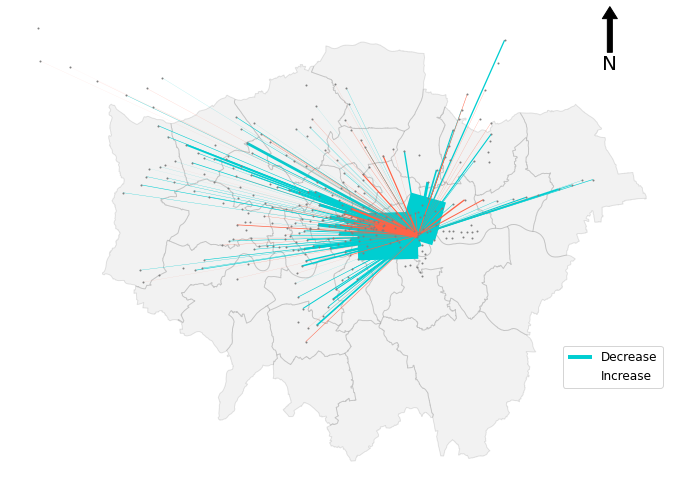

In [903]:
# let's see the change of the flows that regared this place as detination (i.e. passengers go to this place)
CreateGraph(flows_A_2)
plt.savefig('Figure4a_inflow.png',dpi=600)
plt.show()

In [780]:
flows_A_2['Change']=0
flows_A_2['Change']=flows_A_2['prodsimest5']-flows_A_2['Flows']
flows_A_2['Change_decrease']=0
    
for i in flows_A_2.index:
    if flows_A_2.Change[i]<0:
        flows_A_2['Change_decrease'][i]=flows_A_2.Change[i]*(-1)
        flows_A_2.Change[i]=0
    else:
        flows_A_2['Change_decrease'][i]=0

b=flows_A_2.merge(NameDF,left_on='Orig',right_on=NameDF.index,how='left')

b_1=b.sort_values('Change',axis = 0,ascending = False)
b_2=b.sort_values('Change_decrease',axis = 0,ascending = False)

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [769]:
'''
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.barh(x - width/2, b_1.prodsimest5[0:10], width, label='New flows')
rects2 = ax.barh(x + width/2, b_1.Flows[0:10], width, label='Initial flows')
ax.legend()
ax.set_yticks(x)
ax.set_yticklabels(list(b_1.station_1_[0:10]))
plt.grid()
plt.savefig('Destination_increse.png',dpi=600)
plt.show()
'''

"\nfig, ax = plt.subplots(figsize=(8, 5))\nrects1 = ax.barh(x - width/2, b_1.prodsimest5[0:10], width, label='New flows')\nrects2 = ax.barh(x + width/2, b_1.Flows[0:10], width, label='Initial flows')\nax.legend()\nax.set_yticks(x)\nax.set_yticklabels(list(b_1.station_1_[0:10]))\nplt.grid()\nplt.savefig('Destination_increse.png',dpi=600)\nplt.show()\n"

In [770]:
'''
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.barh(x - width/2, b_2.prodsimest5[0:10], width, label='New flows')
rects2 = ax.barh(x + width/2, b_2.Flows[0:10], width, label='Initial flows')
ax.legend()
ax.set_yticks(x)
ax.set_yticklabels(list(b_2.station_1_[0:10]))
plt.grid()
plt.savefig('Destination_decrease.png',dpi=600)
plt.show()
'''

"\nfig, ax = plt.subplots(figsize=(8, 5))\nrects1 = ax.barh(x - width/2, b_2.prodsimest5[0:10], width, label='New flows')\nrects2 = ax.barh(x + width/2, b_2.Flows[0:10], width, label='Initial flows')\nax.legend()\nax.set_yticks(x)\nax.set_yticklabels(list(b_2.station_1_[0:10]))\nplt.grid()\nplt.savefig('Destination_decrease.png',dpi=600)\nplt.show()\n"

In [781]:
a_1[0:10].to_csv('Top 10 largest change of flows out of 156 (Increase).csv')
a_2[0:10].to_csv('Top 10 largest change of flows out of 156 (Decrease).csv')
b_1[0:10].to_csv('Top 10 largest change of flows into 156 (Increase).csv')
b_2[0:10].to_csv('Top 10 largest change of flows into 156 (Decrease).csv')

## Scenario B

In [267]:
beta_1=beta*2
flows["prodsimest6"] = np.exp(flows["alpha_i"]+gamma*np.log(flows["Jobs"]) + beta_1*flows["Dist"])
flows["prodsimest6"] = round(flows["prodsimest6"],0)
cdatasubmat6 = flows.pivot_table(values ="prodsimest6", index="Orig", columns = "Dest",aggfunc=np.sum, margins=True)
cdatasubmat6

Dest,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,All
Orig,,,,,,,,,,,,,,,,,,,,,
0,NaN,219.0,NaN,185.0,205.0,303.0,100.0,450.0,114.0,40.0,...,NaN,NaN,40.0,41.0,112.0,226.0,94.0,103.0,192.0,16433.0
1,202.0,NaN,49.0,96.0,106.0,157.0,59.0,265.0,59.0,21.0,...,NaN,13.0,21.0,21.0,58.0,117.0,49.0,54.0,100.0,8428.0
2,67.0,37.0,NaN,39.0,43.0,64.0,17.0,77.0,24.0,8.0,...,NaN,NaN,NaN,7.0,22.0,39.0,NaN,NaN,37.0,2231.0
3,151.0,84.0,45.0,NaN,204.0,244.0,39.0,174.0,113.0,39.0,...,2.0,15.0,23.0,24.0,89.0,132.0,55.0,72.0,NaN,10768.0
4,148.0,83.0,44.0,180.0,NaN,239.0,38.0,171.0,117.0,41.0,...,NaN,15.0,23.0,23.0,92.0,130.0,54.0,75.0,140.0,11242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,355.0,199.0,86.0,255.0,283.0,376.0,91.0,410.0,157.0,55.0,...,NaN,95.0,150.0,152.0,124.0,NaN,352.0,114.0,213.0,23230.0
274,170.0,95.0,41.0,122.0,136.0,180.0,NaN,196.0,75.0,26.0,...,NaN,204.0,322.0,327.0,59.0,405.0,NaN,55.0,102.0,12467.0
275,89.0,50.0,24.0,77.0,90.0,123.0,23.0,103.0,55.0,19.0,...,NaN,7.0,11.0,11.0,95.0,63.0,26.0,NaN,163.0,6761.0


In [268]:
beta_2=beta*3
flows["prodsimest7"] = np.exp(flows["alpha_i"]+gamma*np.log(flows["Jobs"]) + beta_2*flows["Dist"])
flows["prodsimest7"] = round(flows["prodsimest7"],0)
cdatasubmat7 = flows.pivot_table(values ="prodsimest7", index="Orig", columns = "Dest",aggfunc=np.sum, margins=True)
cdatasubmat7

Dest,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,All
Orig,,,,,,,,,,,,,,,,,,,,,
0,NaN,212.0,NaN,146.0,160.0,253.0,94.0,399.0,75.0,28.0,...,NaN,NaN,18.0,14.0,62.0,158.0,45.0,74.0,132.0,11730.0
1,196.0,NaN,45.0,73.0,80.0,127.0,57.0,242.0,38.0,14.0,...,NaN,5.0,9.0,7.0,31.0,79.0,23.0,37.0,66.0,5981.0
2,63.0,34.0,NaN,32.0,35.0,56.0,15.0,64.0,17.0,6.0,...,NaN,NaN,NaN,2.0,12.0,26.0,NaN,NaN,26.0,1673.0
3,119.0,65.0,37.0,NaN,201.0,231.0,29.0,122.0,94.0,35.0,...,0.0,6.0,10.0,8.0,56.0,90.0,26.0,56.0,NaN,8138.0
4,115.0,63.0,36.0,177.0,NaN,224.0,28.0,118.0,99.0,37.0,...,NaN,6.0,10.0,8.0,59.0,87.0,25.0,58.0,103.0,8461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,248.0,135.0,57.0,173.0,190.0,255.0,60.0,254.0,89.0,33.0,...,NaN,54.0,93.0,76.0,53.0,NaN,241.0,63.0,112.0,14692.0
274,82.0,45.0,19.0,57.0,63.0,84.0,NaN,84.0,29.0,11.0,...,NaN,169.0,293.0,239.0,18.0,277.0,NaN,21.0,37.0,6182.0
275,64.0,35.0,18.0,59.0,70.0,98.0,16.0,66.0,38.0,14.0,...,NaN,2.0,4.0,3.0,73.0,35.0,10.0,NaN,155.0,4578.0


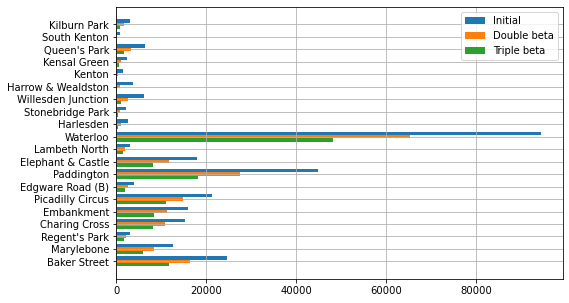

In [830]:
#the number of cities to show
NumberScenarioB=20

# the changes of out-flow in each station
labels = StationNames[0:NumberScenarioB]
x1 = list(cdatasubmat.All)[0:NumberScenarioB]
x2 = list(cdatasubmat6.All)[0:NumberScenarioB]
x3 =list(cdatasubmat7.All)[0:NumberScenarioB]

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

rects1 = ax.barh(x + width/3, x1, width/3, label='Initial')
rects2 = ax.barh(x , x2, width/3, label='Double beta')
rects3 = ax.barh(x - width/3, x3, width/3, label='Triple beta')

ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()

plt.grid()
plt.show()

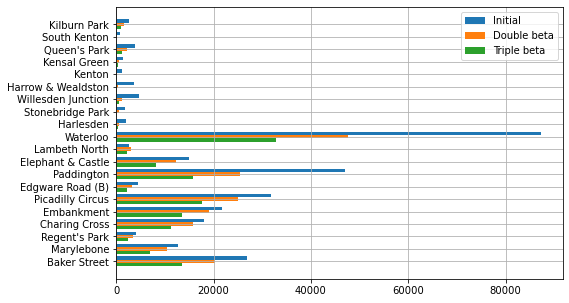

In [837]:
# the changes of in-flow in each station

x4=[]
x5=[]
x6=[]
for i in range(0,NumberScenarioB):
    x4.append(int(cdatasubmat[cdatasubmat.index=='All'][i]))
    x5.append(int(cdatasubmat6[cdatasubmat6.index=='All'][i]))
    x6.append(int(cdatasubmat7[cdatasubmat7.index=='All'][i]))

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.barh(x + width/3, x4, width/3, label='Initial')
rects2 = ax.barh(x , x5, width/3, label='Double beta')
rects3 = ax.barh(x - width/3, x6, width/3, label='Triple beta')

ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()

plt.grid()
plt.savefig('Figure5.png',bbox_inches='tight',dpi=600)
plt.show()

## Compare Scenario A and B

In [850]:
x_beta=[]
y_beta=[]
for i in range(1,10):
    beta_loop=beta*i
    flows["prodsimest_loop"] = np.exp(flows["alpha_i"]+gamma*np.log(flows["Jobs"]) + beta_loop*flows["Dist"])
    flows["prodsimest_loop"] = round(flows["prodsimest_loop"],0)
    cdatasubmat_loop = flows.pivot_table(values ="prodsimest_loop", index="Orig", columns = "Dest",aggfunc=np.sum, margins=True)
    Total=int(cdatasubmat_loop[cdatasubmat_loop.index=='All']['All'])
    y_beta.append(Total)
    x_beta.append(-beta_loop)

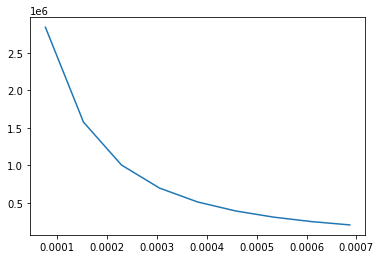

In [851]:
plt.plot(x_beta,y_beta)

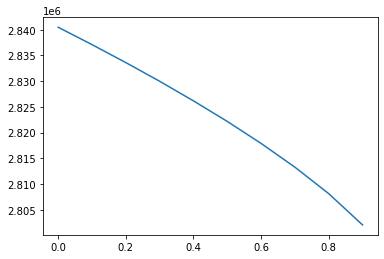

In [856]:
x_job=[]
y_job=[]
for i in range(0,10):  # i represents 10% of the decrease of the number of jobs
    def new_sal(row):
        if row["Dest"] == 156: val = job*(10-i)*0.1
        else: val = row["Jobs"]
        return val
        
    flows["Job_scenario_A_loop"] = flows.apply(new_sal, axis =1)
    
    flows["prodsimest_loop"] = np.exp(flows["alpha_i"]+gamma*np.log(flows["Job_scenario_A_loop"]) + beta*flows["Dist"])
    flows["prodsimest_loop"] = round(flows["prodsimest_loop"],0)
    cdatasubmat_loop = flows.pivot_table(values ="prodsimest_loop", index="Orig", columns = "Dest",aggfunc=np.sum, margins=True)
    
    Total=int(cdatasubmat_loop[cdatasubmat_loop.index=='All']['All'])
    y_job.append(Total)
    x_job.append(i/10)

plt.plot(x_job,y_job)

In [881]:
compare

,Orig,Dest,Initial flows,Population,Jobs,Dist,Scenario A,Scenario B (Double Beta),Scenario B (Triple Beta)
0,0,1,35,24582,12652,416,226.0,219.0,212.0
1,2,1,43,3128,12652,1150,41.0,37.0,34.0
2,3,1,623,15330,12652,3507,110.0,84.0,65.0
3,4,1,283,15961,12652,3686,110.0,83.0,63.0
4,5,1,454,21228,12652,2817,144.0,116.0,94.0
...,...,...,...,...,...,...,...,...,...
33924,155,42,22,27042,313,20573,4.0,1.0,0.0
33925,156,42,0,53207,313,14088,18.0,6.0,2.0
33926,214,42,0,14139,313,21198,2.0,0.0,0.0
33927,215,42,30,33973,313,19827,5.0,1.0,0.0


In [880]:
compare=flows[['Orig','Dest','Flows','Population','Jobs','Dist','prodsimest5','prodsimest6','prodsimest7']]
compare.rename(columns={'Flows':'Initial flows'},inplace=True)
compare.rename(columns={'prodsimest5':'Scenario A'},inplace=True)
compare.rename(columns={'prodsimest6':'Scenario B (Double Beta)'},inplace=True)
compare.rename(columns={'prodsimest7':'Scenario B (Triple Beta)'},inplace=True)

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [885]:
NameDF['Initial flows']=0
NameDF['Scenario A']=0
NameDF['Scenario B (Double Beta)']=0
NameDF['Scenario B (Triple Beta)']=0
for i in range(0,len(compare)):
    ind=compare['Dest'][i]
    NameDF['Initial flows'][ind]=NameDF['Initial flows'][ind]+compare['Initial flows'][i]
    NameDF['Scenario A'][ind]=NameDF['Scenario A'][ind]+compare['Scenario A'][i]
    NameDF['Scenario B (Double Beta)'][ind]=NameDF['Scenario B (Double Beta)'][ind]+compare['Scenario B (Double Beta)'][i]
    NameDF['Scenario B (Triple Beta)'][ind]=NameDF['Scenario B (Triple Beta)'][ind]+compare['Scenario B (Triple Beta)'][i]

D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\GIS\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\GIS\anaconda3\envs\urbsim\lib\site-packages

In [888]:
NameDF['ChangeA%']=(NameDF['Scenario A']/NameDF['Initial flows']-1)*100
NameDF['ChangeB2%']=(NameDF['Scenario B (Double Beta)']/NameDF['Initial flows']-1)*100
NameDF['ChangeB3%']=(NameDF['Scenario B (Triple Beta)']/NameDF['Initial flows']-1)*100

In [919]:
print(max(NameDF['ChangeA%']))
print(max(NameDF['ChangeB2%']))
print(max(NameDF['ChangeB3%']))

85.61040949100651
16.45618063528511
-18.790662074244167


In [918]:
print(min(NameDF['ChangeA%']))
print(min(NameDF['ChangeB2%']))
print(min(NameDF['ChangeB3%']))

-80.50986842105263
-94.4078947368421
-97.61171032357473


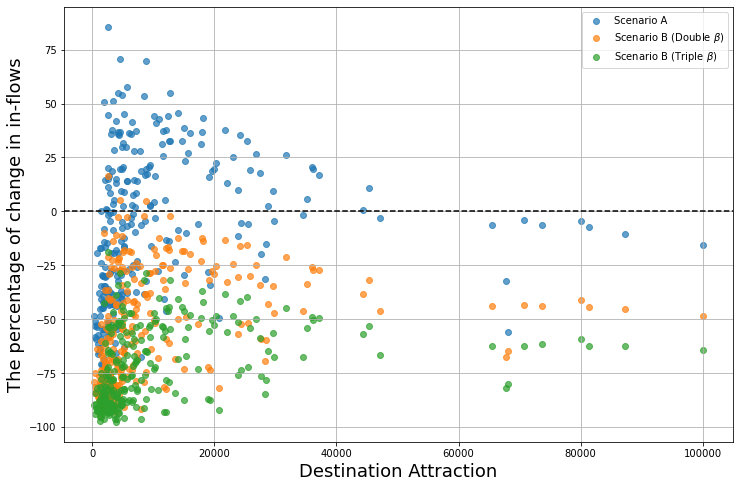

In [908]:
fig, ax = plt.subplots(figsize=(12,8))

alpha=0.7

plt.scatter(NameDF['Initial flows'],NameDF['ChangeA%'],alpha=alpha,label='Scenario A')
plt.scatter(NameDF['Initial flows'],NameDF['ChangeB2%'],alpha=alpha,label=r'Scenario B (Double $\beta$)')
plt.scatter(NameDF['Initial flows'],NameDF['ChangeB3%'],alpha=alpha,label=r'Scenario B (Triple $\beta$)')
plt.axhline(color="black", linestyle="--")
ax.legend()
ax.grid(True)
ax.set_xlabel('Destination Attraction', fontsize=18)
ax.set_ylabel('The percentage of change in in-flows', fontsize=18)
plt.savefig('Figure6_compare.png',dpi=600)
plt.show()